In [1]:
import tensorflow as tf

import pandas as pd

import numpy as np

import time

from sklearn.datasets import load_iris

from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt

D:\Installation\Anaconda\envs\mlearning\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 设置数据，并查看数据集大小
# 通过train_test_split函数中的设置，将数据集按1:3的比例分割了数据，分别作为训练集和测试集

iris = load_iris()

iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]

iris_y= pd.get_dummies(iris_y).values

trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

print(trainX.shape)

print(testX.shape)

print(trainY.shape)

print(testY.shape)

(99, 4)
(50, 4)
(99, 3)
(50, 3)


In [3]:
# 设置占位符和变量

# numFeatures是我们输入数据中的特征数量。

# 在iris数据集中，这个数字是'4'

numFeatures = trainX.shape[1]

# numLabels使我们数据集的类的数量

# 在iris数据集中，这个数字是'3'

numLabels = trainY.shape[1]

# 占位符

# 'None' 意味着TensorFlow不应该期望在该维度中有一个固定的数字

X = tf.placeholder(tf.float32, [None, numFeatures]) # Iris 有4个特征，所以X是来保存我们的数据的张量

yGold = tf.placeholder(tf.float32, [None, numLabels]) # 这将是我们的3个类矩阵的正确答案

W = tf.Variable(tf.zeros([4, 3]))  # 4维输入和3个类

b = tf.Variable(tf.zeros([3])) # 3维输出 [0,0,1],[0,1,0],[1,0,0]

#随机抽取标准偏差为.01的正态分布

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=0.01,
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=0.01,
                                    name="bias"))

In [4]:
# 定义Logistic回归

# Logistic回归方程的三要素分解

# 注意这些feed到其他

apply_weights_OP = tf.matmul(X, weights, name="apply_weights")

add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 

activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

In [5]:
# 设置迭代次数和学习率

# 我们训练中的Epochs数

numEpochs = 700

# 定义我们的学习率迭代 (衰减)

learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [6]:
# 设置损失函数

#定义我们的成本函数 - 平方均值误差

cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

#定义我们的渐变下降

training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

In [7]:
# 初始化会话

# 创建一个tensorflow会话

sess = tf.Session()

# 初始化我们的权重和偏差变量

init_OP = tf.global_variables_initializer()

# 初始化所有tensorflow变量

sess.run(init_OP)

In [8]:
# 设置一些变量追踪训练

# argmax(activation_OP, 1)以最大概率返回标签

# argmax(yGold, 1)是正确的标签

correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))

# 如果每个错误预测为0并且每个真实预测为1，则平均值会返回我们的准确性

accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# 汇总op的回归输出

activation_summary_OP = tf.summary.histogram("output", activation_OP)

# 汇总op的准确度

accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)

# 汇总op的成本

cost_summary_OP = tf.summary.scalar("cost", cost_OP)

# 汇总检查每次迭代后变量(W, b) 是如何更新

weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))

biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))

# 合并所有的汇总

merged = tf.summary.merge([activation_summary_OP, accuracy_summary_OP, cost_summary_OP, weightSummary, biasSummary])

# 汇总writer

writer = tf.summary.FileWriter("summary_logs", sess.graph)

In [9]:
# 开始训练，并输出训练过程

# 初始化报告变量

cost = 0

diff = 1

epoch_values = []

accuracy_values = []

cost_values = []

# 训练 epochs

for i in range(numEpochs):

    if i > 1 and diff < .0001:

        print("change in cost %g; convergence."%diff)

        break

    else:

        # 运行训练

        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})

        # Report occasional stats

        if i % 100 == 0:

            # 将epoch添加到epoch_values

            epoch_values.append(i)

            # 基于测试集数据生成准确度

            train_accuracy, newCost = sess.run([accuracy_OP, cost_OP], feed_dict={X: trainX, yGold: trainY})

            # 为实时图形变量添加准确性

            accuracy_values.append(train_accuracy)

            # 为实时图形变量添加成本

            cost_values.append(newCost)

            # 对变量重新分配值

            diff = abs(newCost - cost)

            cost = newCost

            #生成输出语句

            print("step %d, training accuracy %g, cost %g, change in cost %g"%(i, train_accuracy, newCost, diff))

# How well do we perform on held-out test data?

print("final accuracy on test set: %s" %str(sess.run(accuracy_OP,
                                                     feed_dict={X: testX,
                                                                yGold: testY})))

step 0, training accuracy 0.333333, cost 34.1082, change in cost 34.1082
step 100, training accuracy 0.656566, cost 20.634, change in cost 13.4742
step 200, training accuracy 0.717172, cost 18.052, change in cost 2.58202
step 300, training accuracy 0.79798, cost 16.9019, change in cost 1.15006
step 400, training accuracy 0.848485, cost 16.1776, change in cost 0.724348
step 500, training accuracy 0.878788, cost 15.6446, change in cost 0.533012
step 600, training accuracy 0.909091, cost 15.2205, change in cost 0.424069
final accuracy on test set: 0.9


D:\Installation\Anaconda\envs\mlearning\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Installation\Anaconda\envs\mlearning\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


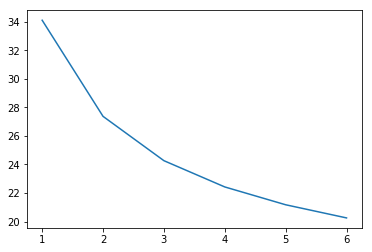

In [10]:
# 查看训练过程损失值变化情况

%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt

plt.plot([np.mean(cost_values[i-50:i]) for i in range(len(cost_values))])

plt.show()